# 实验二 利用PCA进行图片压缩
选择airplane数据集

In [1]:
# 导入必要Python库
import numpy as np
from PIL import Image
import os
import time
import pandas as pd

## QR分解求全部特征值

In [191]:
# QR分解
# 返回降序的特征值特征向量
def qr_eig(A):
    num_iter = 100
    n = A.shape[0]

    Q_total = np.eye(n)  # 相当于S
    R = A.copy() # 相当于Ak

    for _ in range(num_iter):
        Q, R = np.linalg.qr(R)
        R = np.dot(R, Q)
        Q_total = np.dot(Q_total, Q)

    eigvals = np.diag(R)
    eigvecs = Q_total
    # 获取排序的索引
    idx = np.argsort(eigvals)[::-1]
    # 用索引来排序特征值和特征向量
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    return eigvals, eigvecs

def qr_pca(picpath, threshold=0.9):
    # 读取图片，并转化成2维矩阵
    image = Image.open(path+pic).convert('RGB')
    imarray = np.array(image)
    im256_768 = np.vstack((imarray[:,:,0], imarray[:,:,1], imarray[:,:,2]))
    # im256_768 = imarray.reshape((256,768))
    n = im256_768.shape[0]

    # 中心化，标准化
    mean = np.mean(im256_768, axis=0).reshape(1,-1)
    sds = n-1
    im_centered = (im256_768 - mean)/sds # 这里一定要做标准化，因为行之间存在相关性

    # 协方差矩阵
    cov = im_centered.T @ im_centered

    # 特征值特征向量
    Sigma, U = qr_eig(cov)

    # 按照threshold计算k
    sigma_sum = np.sum(Sigma)
    Sigma_cumsum = np.cumsum(Sigma/sigma_sum)
    k = np.argwhere(Sigma_cumsum>threshold)[0][0]

    # 计算主成分
    im_256_k = (im_centered @ U)[:,:k]

    # reconstruct
    im_pca = (im_256_k @ U.T[:k,:])*sds+mean
    im_pca = im_pca.astype('uint8')
    channels = np.vsplit(im_pca, 3)
    im_res = np.zeros_like(imarray)
    for i in range(3):
        im_res[:,:,i] = channels[i]
    return Image.fromarray(im_res)

In [3]:
# 计算压缩率和重构误差
def get_cr(srcpath, dirpath):
    srcsz = os.path.getsize(srcpath)
    dirsz = os.path.getsize(dirpath)
    return round((srcsz-dirsz)/srcsz, 4)
def get_mse(srcpath, dirpath):
    a = np.array(Image.open(srcpath))
    b = np.array(Image.open(dirpath))
    return round(np.square(a-b).mean(), 4)

## 幂法+降阶技术 求前k特征值

In [276]:
# 幂法
# A: mat
# return: (特征值，特征向量)
def PowerMethod(A, eps=0.001):
    v_old = np.random.random(A.shape[0])[:,None]
    max_iter = 100
    for _ in range(max_iter):
        v_new = A@v_old
        v_new = v_new/(np.linalg.norm(v_new))
        if np.linalg.norm(v_new - v_old) <=eps:
            break
        v_old = v_new
    lam = v_new.T@A@v_new
    return lam[0,0],v_new.reshape(-1)
# 求前k大特征值和对应的特征向量
def power_eig(A, k):
    n = A.shape[0]
    w = np.zeros(k)
    U = np.zeros((n,k))
    for i in range(k):
        w1,u1 = PowerMethod(A)
        w[i] = w1
        U[:,i] = u1
        A = A-w1*u1.T@u1
    return w,U

In [277]:
def power_pca(picpath, k):
    # 读取图片，并转化成2维矩阵
    image = Image.open(path+pic).convert('RGB')
    imarray = np.array(image)
    # im25536_3 = np.hstack((imarray[:,:,0], imarray[:,:,1], imarray[:,:,2]))
    im25536_3 = imarray.reshape((-1,3))
    n = im25536_3.shape[0]

    # 中心化，标准化
    mean = np.mean(im25536_3, axis=0).reshape(1,-1)
    sds = 1
    im_centered = (im25536_3 - mean)/sds

    # 协方差矩阵
    cov = im_centered.T @ im_centered

    # 特征值特征向量
    # print(np.linalg.eigh(cov.copy()))
    Sigma, Uk = power_eig(cov.copy(), k)
    # print(Sigma,Uk)
    # 计算主成分
    im_256_k = (im_centered @ Uk)

    # reconstruct
    im_pca = (im_256_k @ Uk.T)*sds+mean
    im_pca = im_pca.astype('uint8')
    im_res = im_pca.reshape((256,256,3))
    # channels = np.hsplit(im_pca, 3)
    # im_res = np.zeros_like(imarray)
    # for i in range(3):
    #     im_res[:,:,i] = channels[i]
    return Image.fromarray(im_res)

In [281]:
res = {'pic':[],'time_spend':[],'compact_rate':[],'MSE':[]}
path = './lab2-图像压缩/Images/airplane/'
pics = os.listdir(path)
for pic in pics:
    impath = path+pic
    pca_pic_path = './power_pca/'+pic
    start = time.time()
    resim = power_pca(impath, 2)
    time_spend = time.time() - start
    resim.save(pca_pic_path)
    compact_rate = get_cr(impath, pca_pic_path)
    mse = get_mse(impath, pca_pic_path)
    res['pic'].append(pic)
    res['time_spend'].append(time_spend)
    res['compact_rate'].append(compact_rate)
    res['MSE'].append(mse)
pd.DataFrame(res).to_csv('./power_pca_res.csv')

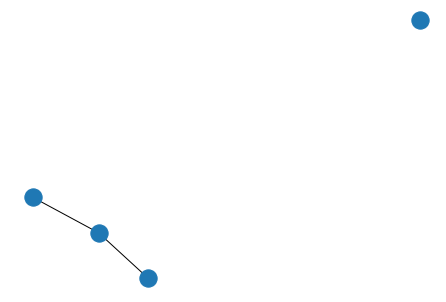

In [3]:
import networkx as nx
G = nx.graph_atlas(10)
nx.draw(G)